# Sparkify Capstone Project
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Use this subset data to build project before deploying cluster on the cloud.

In [2]:
# import libraries
import time
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import substring, col, round, when
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import rank

import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, MinMaxScaler, StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [4]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Capstone Project") \
    .getOrCreate()

# 1. Load and clean dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [76]:
# load data
path = r"C:\Users\DJ\Documents\git\DSND_Term2\capstone\Spark Capstone\mini_sparkify_event_data.json"
df = spark.read.json(path)

In [77]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [78]:
df1 = df.select('length', 'registration', "userId", "sessionId")

In [79]:
df1.count()

286500

In [10]:
from functools import reduce
from pyspark.sql.functions import count, isnan, trim

In [80]:
df1.where(reduce(lambda x, y: x | y, (F.col(x).isNull() for x in df1.columns))).show()

+------+-------------+------+---------+
|length| registration|userId|sessionId|
+------+-------------+------+---------+
|  null|1538173362000|    30|       29|
|  null|1538331630000|     9|        8|
|  null|1538331630000|     9|        8|
|  null|1532482662000|    54|       53|
|  null|1532482662000|    54|       53|
|  null|1538331630000|     9|        8|
|  null|1538331630000|     9|        8|
|  null|1538331630000|     9|        8|
|  null|1537365219000|    74|      217|
|  null|         null|      |        8|
|  null|         null|      |        8|
|  null|         null|      |        8|
|  null|         null|      |        8|
|  null|1538331630000|     9|        8|
|  null|1538173362000|    30|       29|
|  null|1538169823000|     4|      240|
|  null|         null|      |      240|
|  null|         null|      |      240|
|  null|1538169823000|     4|      240|
|  null|1537365219000|    74|      217|
+------+-------------+------+---------+
only showing top 20 rows



In [81]:
df1.select([count(when(isnan(c) | col(c).isNull() | (col(c)==""), c
                      )
                 ).alias(c) for c in df1.columns]
          ).show()

+------+------------+------+---------+
|length|registration|userId|sessionId|
+------+------------+------+---------+
| 58392|        8346|  8346|        0|
+------+------------+------+---------+



In [65]:
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

In [74]:
df1a = df1.select([to_null(c).alias(c) for c in df1.columns]).na.drop()

In [75]:
df1a.count()

228108

In [59]:
df2.select([count(when(isnan(c) | col(c).isNull() | (col(c)==""), c
                      )
                 ).alias(c) for c in df2.columns]
          ).show()

+------+-----+------+------+-----+---------+-------------+--------------------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+----------------------+
|userId|churn|gender|system|level|totalDays|activeDaysPct|session_perActiveDay|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Logout_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|songHours_perActiveDay|
+------+-----+------+------+-----+---------+-------------+--------------------+---------------+-------------------+-----------------------+-------------------+-------

In [7]:
# drop rows with missing or invalid values in either 'userId' or 'sessionId'
c1 = df.count()
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
c2 = df.count()
df = df.filter(df["userId"] != "")
c3 = df.count()

print("The whole dataset has {} rows. \
\nAfter dropping NA in either 'userId' or 'sessionId', there are {} rows left. \
\nAfter filtering empty 'userId', there are {} rows left".format(c1, c2, c3))

The whole dataset has 286500 rows. 
After dropping NA in either 'userId' or 'sessionId', there are 286500 rows left. 
After filtering empty 'userId', there are 278154 rows left


# 2. Create additional features

In [352]:
# for each user, calculate total number of days from registration
df = df.withColumn("daysSinceRegistration", F.ceil((df.ts - df.registration)/(1000*60*60*24)))
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|daysSinceRegistration|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|                    3|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+------

In [353]:
# convert 'datetime' to easy to read date/datetime format
get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn("datetime", get_datetime(df.ts))

get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
df = df.withColumn("date", get_date(df.ts))

df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|daysSinceRegistration|           datetime|      date|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|                    3|2018-09-30 19:01:57|2018-09-

In [354]:
# label user 'Cancellation Confirmation' as churn
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", flag_cancellation_event("page"))

df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|daysSinceRegistration|           datetime|      date|churn|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|                    3|2018-09-30

In [355]:
# convert user systems into four categories: Windows, Apple, Linux, other
df = df.withColumn('system',
                    when(col("userAgent").contains('Windows'), 'Windows')
                    .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                    .when(col("userAgent").contains('Linux'), 'Linux')
                    .otherwise('other'))
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+-------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|daysSinceRegistration|           datetime|      date|churn| system|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+-------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|        

In [356]:
# create a datetime window to rank each user' activity from latest to earliest
windowval = Window.partitionBy("userId").orderBy(desc("ts"))
df = df.withColumn("rank", rank().over(windowval))

df.show(1)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+------+----+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|daysSinceRegistration|           datetime|      date|churn|system|rank|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+---------------------+-------------------+----------+-----+------+----+
|  null|Logged In| Darianna|     F|           34|Carpenter|  null| free|Bridgeport-Stamfo...|   PUT|Logout|1538016340000|      187|null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|                   56|2018-11-21 12:12:32|20

In [357]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- daysSinceRegistration: long (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- system: string (nullable = false)
 |-- rank: integer (nullable = true)



In [358]:
n_users = df.select('userId').dropDuplicates().count()
n_churn = df.filter(df.churn == 1).select('userId').dropDuplicates().count()

f"df has a total of {n_users} users. Among them, {n_churn} churned."

'df has a total of 225 users. Among them, 52 churned.'

In [359]:
# find each user's latest status of churn, gender, system, level
df1 = df.select('userId', 'churn', 'gender', 'system', 'level').filter(df.rank == 1)

df1.show(3)

+------+-----+------+------+-----+
|userId|churn|gender|system|level|
+------+-----+------+------+-----+
|100010|    0|     F| Apple| free|
|200002|    0|     M| Apple| paid|
|   125|    0|     M| Apple| free|
+------+-----+------+------+-----+
only showing top 3 rows



In [360]:
# find each users' total number of songs listened, and the total length/duration of songs listened
df2 = df.filter(df.page == 'NextSong').groupBy("userId") \
        .agg((F.sum('length')/(60*60)).alias('songHours'), F.count('userId').alias('n_NextSong'))

df2.show(3)

+------+------------------+----------+
|userId|         songHours|n_NextSong|
+------+------------------+----------+
|100010|18.594693708333335|       275|
|200002|26.113576649999978|       387|
|   125|0.5803091944444446|         8|
+------+------------------+----------+
only showing top 3 rows



In [361]:
# find each users' total number of days (from registration dateto latest activity date)
# find each users' actual number of active days divided by the total number of days
# find each user' total number of sessions divided by the number of active days
# find each user's total number of page items divided by the total number of sessions    
df3 = df.groupBy("userId") \
        .agg(F.max('daysSinceRegistration').alias('totalDays'), F.count('itemInsession').alias('item_ct'), \
             F.countDistinct('sessionId').alias('session_ct'), F.countDistinct('date').alias('activeDays'))

df3 = df3.withColumn('activeDaysPct', df3.activeDays/df3.totalDays) \
         .withColumn('session_perActiveDay', df3.session_ct/df3.activeDays) \
         .withColumn('item_perSession', df3.item_ct/df3.session_ct) \
         .drop('item_ct', 'session_ct')

df3.show(3)

+------+---------+----------+--------------------+--------------------+-----------------+
|userId|totalDays|activeDays|       activeDaysPct|session_perActiveDay|  item_perSession|
+------+---------+----------+--------------------+--------------------+-----------------+
|200002|       71|         6| 0.08450704225352113|                 1.0|             79.0|
|100010|       56|         8| 0.14285714285714285|               0.875|54.42857142857143|
|   125|       72|         1|0.013888888888888888|                 1.0|             11.0|
+------+---------+----------+--------------------+--------------------+-----------------+
only showing top 3 rows



In [362]:
# this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
# ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
df4 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)

# https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
# rename names for each page
pages_column_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df4.columns[1:]))
new_columns_list = pages_column_list.copy()
new_columns_list.insert(0, df4.columns[0])
df4 = df4.toDF(*new_columns_list)

# for each user, calculate the average number of page views per song (NextSong)
# keep 5 decimal
for col_name in df4.columns:
    if col_name not in ('userId', 'n_NextSong'):
        df4 = df4.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))

# after calculating the average number of page views per song, drop the total number of page views for each user
df4 = df4.drop(*pages_column_list)
df4.show(1)

+------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+
|userId|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Logout_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|
+------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+
|200002|        0.00775|       

In [363]:
# join all dataframes together to get the features
df5 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId')

# create two more potential numeric features
df5 = df5.withColumn('songs_perActiveDay', round(df5.n_NextSong/df5.activeDays, 1))
df5 = df5.withColumn('songHours_perActiveDay', round(df5.songHours/df5.activeDays, 2))

# cache for later usage
df5.cache()

df5.show(1)

+------+-----+------+------+-----+------------------+----------+---------+----------+-------------------+--------------------+-----------------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+------------------+----------------------+
|userId|churn|gender|system|level|         songHours|n_NextSong|totalDays|activeDays|      activeDaysPct|session_perActiveDay|  item_perSession|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Logout_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|songs_perActiveDay|songHours_perActiveDay

In [364]:
# check cache status
# To un-cache a dataframe, use unpersist()
df5.storageLevel

StorageLevel(True, True, False, True, 1)

# 3. Check feature correlation. Drop features having correlation >= .8

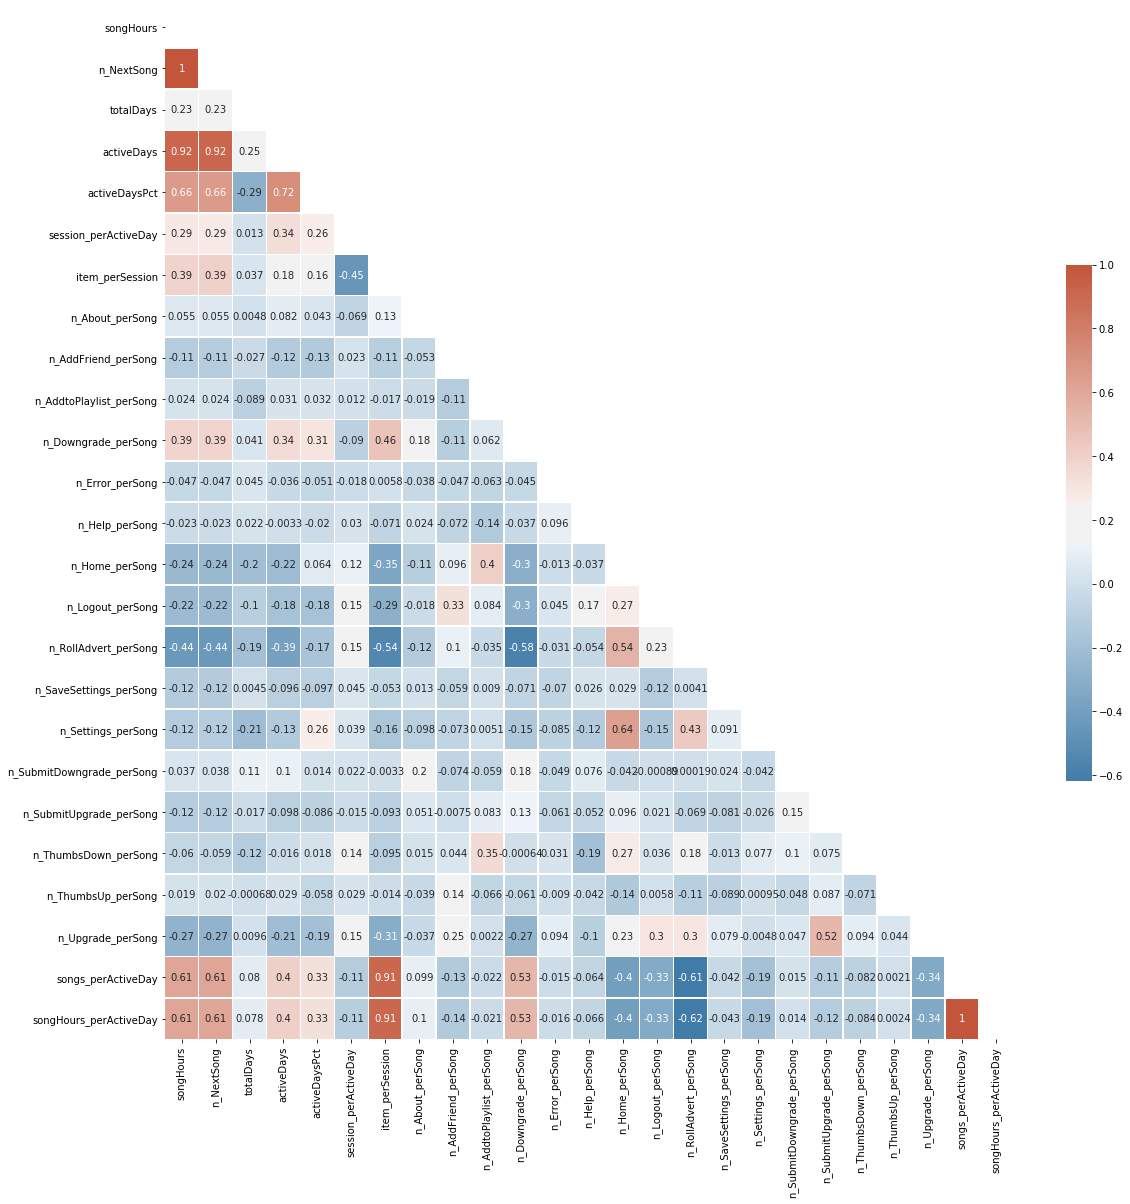

In [365]:
numeric_cols = [f.name for f in df5.schema.fields if isinstance(f.dataType, (DoubleType, LongType))]

df_numeric_cols_panda = df5.select(numeric_cols).toPandas()
corrMatrix = df_numeric_cols_panda.corr()

# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(240, 20, sep=20, n=20, as_cmap=True)
plt.figure(figsize=(19,19))
sn.heatmap(corrMatrix, annot=True, cmap=cmap, mask=mask, linewidths=.5, linecolor='white', cbar_kws={"shrink": .5})
plt.show()

In [366]:
# drop columns with correlation > 0.8
numeric_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']

# numeric columns after dropping high correlation features
numeric_cols = list(set(numeric_cols) - set(numeric_cols_drop))

df5 = df5.drop(*numeric_cols_drop)

In [367]:
# 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
# categorical_cols = ['gender', 'system', 'level']
categorical_cols = [f.name for f in df5.schema.fields if isinstance(f.dataType, StringType)]
categorical_cols.remove('userId')
categorical_cols

['gender', 'system', 'level']

In [368]:
# matplotlib accepts pandas dataframe for plotting. Convert pyspark dataframe df5 to pandas dataframe 
# created another column 'churn_label' for plotting purpose
pandas_df5 = df5.toPandas()
pandas_df5['churn_label']= pandas_df5['churn'].map({1:'churn', 0:'not churn'})
pandas_df5.head(3)

,userId,churn,gender,system,level,totalDays,activeDaysPct,session_perActiveDay,n_About_perSong,n_AddFriend_perSong,...,n_RollAdvert_perSong,n_SaveSettings_perSong,n_Settings_perSong,n_SubmitDowngrade_perSong,n_SubmitUpgrade_perSong,n_ThumbsDown_perSong,n_ThumbsUp_perSong,n_Upgrade_perSong,songHours_perActiveDay,churn_label
0,100010,0,F,Apple,free,56,0.142857,0.875,0.00364,0.01455,...,0.18909,0.0,0.00000,0.0,0.00000,0.01818,0.06182,0.00727,2.32,not churn
1,200002,0,M,Apple,paid,71,0.084507,1.000,0.00775,0.01034,...,0.01809,0.0,0.00775,0.0,0.00258,0.01550,0.05426,0.00517,4.35,not churn
2,125,0,M,Apple,free,72,0.013889,1.000,0.00000,0.00000,...,0.12500,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.58,not churn


# 4. Exploratory Data Analysis

### Number of users who churn vs not churn between/among gender/system/level
**Below countplots show clearly:**
1. Linux users have a higer percentage of churn users than not churn users.

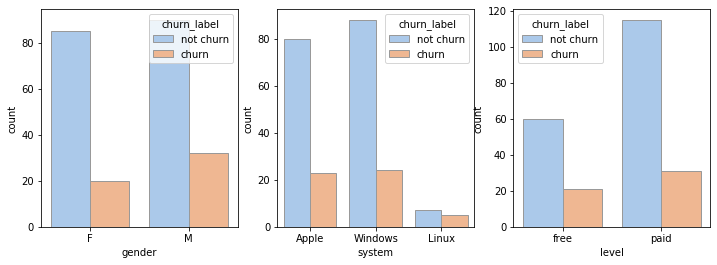

In [369]:
plt.figure(figsize=(12, 4))

for i, col in enumerate(categorical_cols):
    plt.subplot(1,3,i+1)
    sn.countplot(x=col, hue="churn_label", palette="pastel", edgecolor=".6", data=pandas_df5);

### Boxplot of all numeric values between churn and not churn
**Boxplots below show:**
1. Compared to not churn users, churn users have on average, more ThumbsDown_perSong, more session_perActiveDay, more RollAdvert_perSong,  higher Upgrade_perSong, higher Home_perSong, higher Settings_perSong, SaveSettings_perSong,  higher ThumbsDown_perSong than not churn users.
2. Compared to not churn users, churn users have on average, less songHours_perActiveDay, less About_perSong, less totalDays, less AddFriend_perSong, less ThumbsUp_perSong than not churn users.

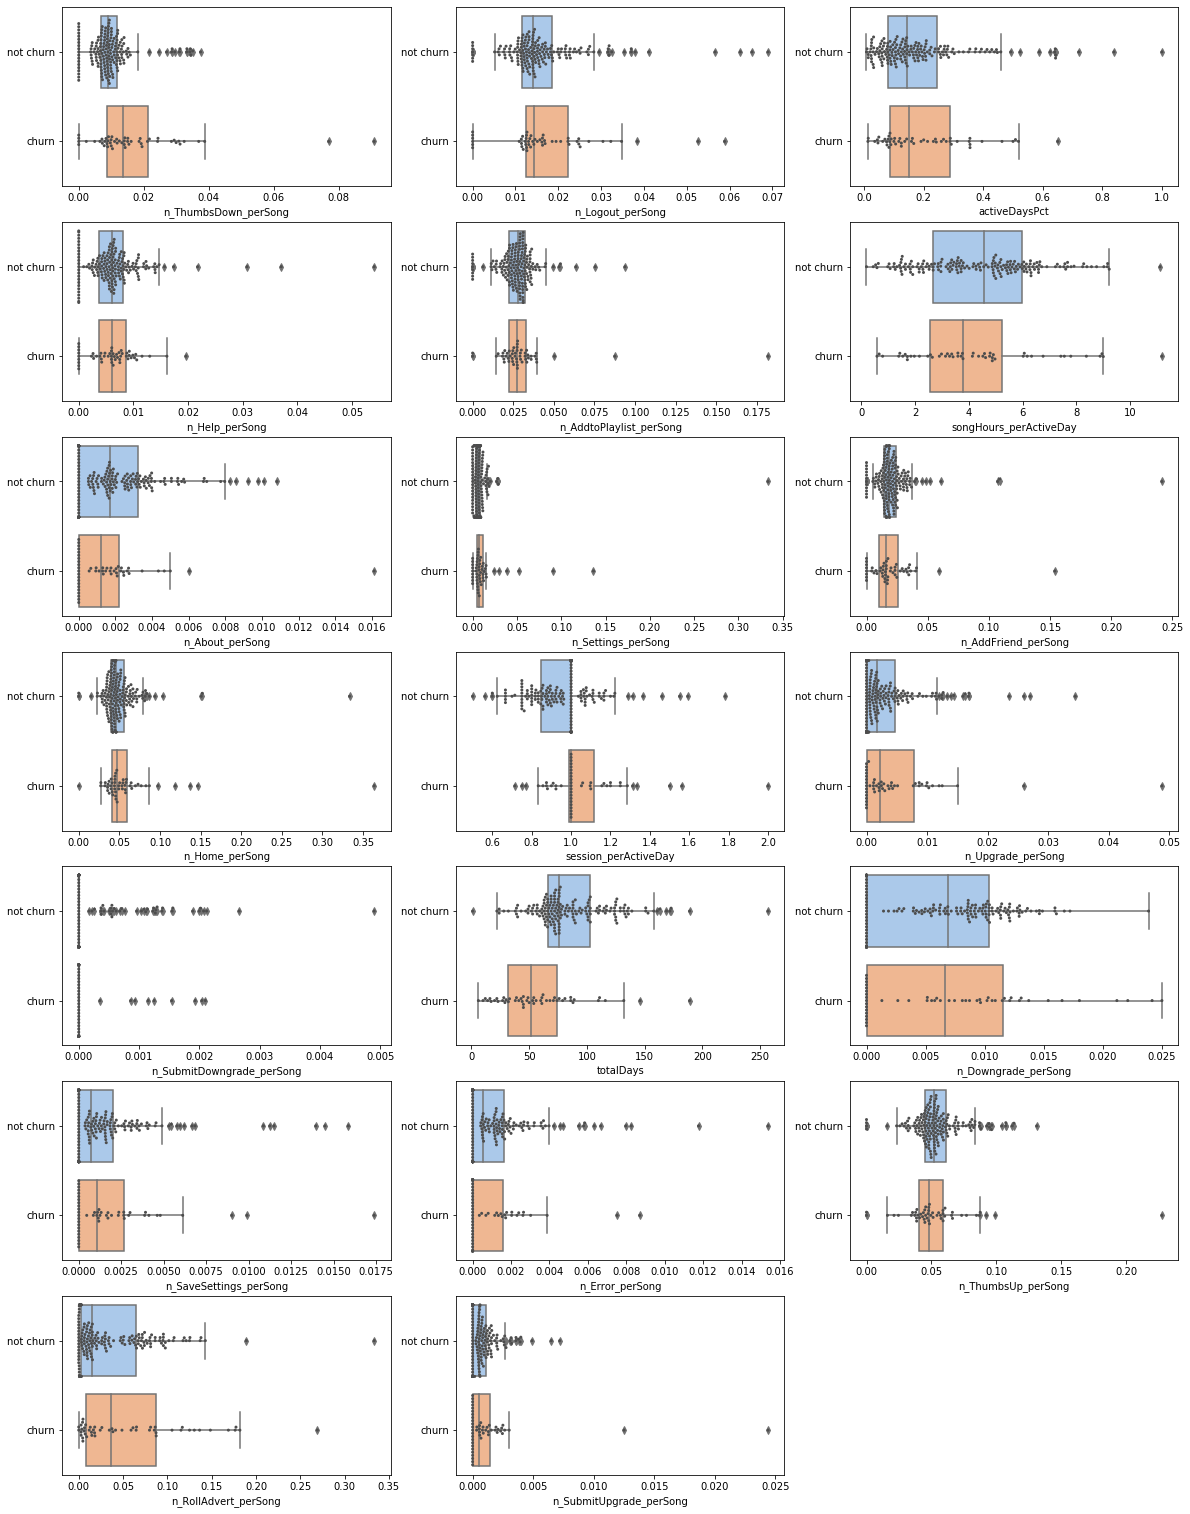

In [370]:
fig = plt.figure(figsize=(20, 27))

for i, col in enumerate(numeric_cols):
    ax = fig.add_subplot(7,3,i+1)
    sn.boxplot(x=col, y="churn_label", data=pandas_df5, palette="pastel", ax=ax)
    sn.swarmplot(x=col, y="churn_label", data=pandas_df5, size=3, color=".3", linewidth=0)
    ax.set(ylabel="")

In [371]:
df5.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- system: string (nullable = false)
 |-- level: string (nullable = true)
 |-- totalDays: long (nullable = true)
 |-- activeDaysPct: double (nullable = true)
 |-- session_perActiveDay: double (nullable = true)
 |-- n_About_perSong: double (nullable = true)
 |-- n_AddFriend_perSong: double (nullable = true)
 |-- n_AddtoPlaylist_perSong: double (nullable = true)
 |-- n_Downgrade_perSong: double (nullable = true)
 |-- n_Error_perSong: double (nullable = true)
 |-- n_Help_perSong: double (nullable = true)
 |-- n_Home_perSong: double (nullable = true)
 |-- n_Logout_perSong: double (nullable = true)
 |-- n_RollAdvert_perSong: double (nullable = true)
 |-- n_SaveSettings_perSong: double (nullable = true)
 |-- n_Settings_perSong: double (nullable = true)
 |-- n_SubmitDowngrade_perSong: double (nullable = true)
 |-- n_SubmitUpgrade_perSong: double (nullable = true)
 |-- n_Thu

In [372]:
f"df5 has a total of {len(df5.columns)} columns. Among them, there are {len(numeric_cols)} numeric columns, \
and {len(categorical_cols)} categorical columns. \
The rest 2 columns will not be used for analysis. They are 'userId', 'churn'."

"df5 has a total of 25 columns. Among them, there are 20 numeric columns, and 3 categorical columns. The rest 2 columns will not be used for analysis. They are 'userId', 'churn'."

# 5. VectorAssembler and Scaler
1. For Logistic Regression model, scale numeric columns will help compare feature importance much easier.
2. Random Forest and Gradient Boost Trees are tree-based model and hence does not require feature scaling.

For this project, I will compare model metrics before doing any feature scaling. If Logistic Regression model's metrics are no better than the other two models, then feature scaling is not needed.

In [373]:
stages = []

for col in categorical_cols:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[col + "Index"], outputCols=[col + "Vec"], dropLast=False)
    stages += [stringIndexer, encoder]

In [375]:
label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_indexer]

In [376]:
numericInputs = numeric_cols
categoricalInputs = [c + "Vec" for c in categorical_cols]
assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
stages += [assembler]

In [377]:
# check the stages
stages

[StringIndexer_67905ea1eeb5,
 OneHotEncoderEstimator_8cc45be28414,
 StringIndexer_cfbea197e3b6,
 OneHotEncoderEstimator_61c7968517c5,
 StringIndexer_862c508024d5,
 OneHotEncoderEstimator_0c5e02a3b2da,
 VectorAssembler_bcda1f4a98cc,
 MinMaxScaler_338136fa38dd,
 VectorAssembler_19a12df038f6,
 MinMaxScaler_be37f2127b89,
 VectorAssembler_cb13f082d6a0,
 MinMaxScaler_2fd33331aac9,
 VectorAssembler_f0186ad401ef,
 MinMaxScaler_3ddeb703fb78,
 VectorAssembler_b93ee858e364,
 MinMaxScaler_843442fdd584,
 VectorAssembler_352a4332c5c7,
 MinMaxScaler_aa3c1b20f9cc,
 VectorAssembler_5fe19a02f293,
 MinMaxScaler_28a1eced0a76,
 VectorAssembler_bdad920cbf94,
 MinMaxScaler_d31d2e009637,
 VectorAssembler_585f8fab2441,
 MinMaxScaler_c7005712ec67,
 VectorAssembler_7b1a74e74eb5,
 MinMaxScaler_c2cd20abcb21,
 VectorAssembler_de8b2a40a8e7,
 MinMaxScaler_70ecec77b607,
 VectorAssembler_21eaa1ce9809,
 MinMaxScaler_db55a5626a2f,
 VectorAssembler_dcfce758aad3,
 MinMaxScaler_f13ed29e8eee,
 VectorAssembler_59c2fc5ae93b,
 

In [378]:
# craete pipeline, and transform raw data df5 to desired vector format for modeling
pipeline = Pipeline(stages=stages)
df6 = pipeline.fit(df5).transform(df5)

In [379]:
# check if 'system' is indexed and vectorized correctly
df6.toPandas()[['system', 'systemVec']].head(3)

,system,systemVec
0,Apple,"(0.0, 1.0, 0.0)"
1,Apple,"(0.0, 1.0, 0.0)"
2,Apple,"(0.0, 1.0, 0.0)"


In [380]:
# check if 'gender' is indexed and vectorized correctly
df6.toPandas()[['gender', 'genderVec']].head(3)

,gender,genderVec
0,F,"(0.0, 1.0)"
1,M,"(1.0, 0.0)"
2,M,"(1.0, 0.0)"


In [381]:
# check df6 data structure
df6.toPandas().head(3)

,userId,churn,gender,system,level,totalDays,activeDaysPct,session_perActiveDay,n_About_perSong,n_AddFriend_perSong,...,n_Error_perSong_Vec,n_Error_perSong_Scaled,n_ThumbsUp_perSong_Vec,n_ThumbsUp_perSong_Scaled,n_RollAdvert_perSong_Vec,n_RollAdvert_perSong_Scaled,n_SubmitUpgrade_perSong_Vec,n_SubmitUpgrade_perSong_Scaled,label,features
0,100010,0,F,Apple,free,56,0.142857,0.875,0.00364,0.01455,...,[0.0],[0.0],[0.06182],[0.27201126413516963],[0.18909],[0.5672756727567275],[0.0],[0.0],0.0,"[0.19997800021999781, 0.26359286646367985, 0.1..."
1,200002,0,M,Apple,paid,71,0.084507,1.000,0.00775,0.01034,...,[0.0],[0.0],[0.05426],[0.23874686496237957],[0.01809],[0.05427054270542705],[0.00258],[0.1057810578105781],0.0,"[0.17049829501704983, 0.18732782369146003, 0.0..."
2,125,0,M,Apple,free,72,0.013889,1.000,0.00000,0.00000,...,[0.0],[0.0],[0.0],[0.0],[0.125],[0.37500375003750036],[0.0],[0.0],0.0,"(0.0, 0.0, 0.005936379928315411, 0.0, 0.0, 0.0..."


In [382]:
# select data for analysis
df7 = df6.select('label', 'features')

In [383]:
df7.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.19997800021999...|
+-----+--------------------+
only showing top 1 row



In [384]:
# check if original column names can be traced back from the vectorized 'features' column
# this is to make sure we can compare feature importance after model is developed
pd.DataFrame(df7.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + \
             df7.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

,idx,name
7,0,n_ThumbsDown_perSong_Scaled_0
8,1,n_Logout_perSong_Scaled_0
9,2,activeDaysPct_Scaled_0
10,3,n_Help_perSong_Scaled_0
11,4,n_AddtoPlaylist_perSong_Scaled_0
12,5,songHours_perActiveDay_Scaled_0
13,6,n_About_perSong_Scaled_0
14,7,n_Settings_perSong_Scaled_0
15,8,n_AddFriend_perSong_Scaled_0
16,9,n_Home_perSong_Scaled_0


# 6. Modeling using sample dataset
Split the sample dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine the winning model based on test accuracy and report results on the validation set. Since the churned users are an unbalanced subset, I selected AreaUnderROC as the metric to optimize.

### Split into Train and Test data

In [243]:
# check if the data is balanced
df7.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  175|
|  1.0|   52|
+-----+-----+



In [256]:
# churn users are significantly less than not churn users
52/(52 + 173)

0.2311111111111111

In [42]:
# stratified sampling to make sure the train/test datasets have similar churn/not churn ratios to that of the whole dataset
train = df7.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=42)

# use the rest as test dataset
test = df7.subtract(train)

In [302]:
print("Training Dataset records number: " + str(train.count()))
print("Test Dataset records number: " + str(test.count()))

Training Dataset records number: 193
Test Dataset records number: 33


In [65]:
# get counts of churn/not churn users in train dataset
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  147|
|  1.0|   44|
+-----+-----+



In [66]:
# check if the churn/not churn ratio in train dataset is close to that of the whole dataset. it is indeed very close.
44/(147 + 44)

0.23036649214659685

### Define an evaluator
F1 is not used. For unbalanced binary classification, 'areaUnderROC' is recommended.

In [304]:
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')

### Initiate Logistic Regression, create parameter grid and CrossValidator

In [7]:
#1 logistic regression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')

# Create the parameter grid, add hyperparameters, and build the grid
grid1 = ParamGridBuilder() \
        .addGrid(lr.regParam, [0, 0.01, .1]) \
        .addGrid(lr.elasticNetParam, [0, .5, 1]) \
        .addGrid(lr.maxIter, [50, 100, 150]) \
        .build()

In [269]:
# Create the CrossValidator
cv_lr = CrossValidator(estimator=lr,
               estimatorParamMaps=grid1,
               evaluator=evaluator,
               numFolds = 4,
               seed = 42
               )

# 2 hours run
start_time = time.time()
lrModel = cv_lr.fit(train)
print("Logistic regression training time 8 parameter combos --- %s seconds ---" % (time.time() - start_time))

Logistic regression training time 8 parameter combos --- 773.4994778633118 seconds ---


In [270]:
# best model
lr_best_model = lrModel.bestModel

# Use the model to predict the test set
predictions = lr_best_model.transform(test)

### Calculate model metrics

In [271]:
# pyspark dataframe
# TN = predictions_t.filter((predictions_t.label == 0) & (predictions_t.prediction == 0)).count()

# pyspark sql
TN = predictions.filter('label = 0 and prediction = 0').count()
TP = predictions.filter('label = 1 and prediction = 1').count()
FN = predictions.filter('label = 1 and prediction = 0').count()
FP = predictions.filter('label = 0 and prediction = 1').count()
print(TN, TP, FN, FP)

25 0 8 0


In [272]:
# calculate accuracy, precision, recall, F1-score, and areaUnderROC
accuracy = (TN + TP) / (TN + TP + FN + FP)

if TP == 0 and FP == 0:
    precision = 0
else:
    precision = TP / (TP + FP)
    
if TP==0 and FN==0:
    recall = 0
else:
    recall = TP / (TP + FN)
    
if precision==0 and recall==0:
    F=0
else:
    F =  2 * (precision*recall) / (precision + recall)

In [273]:
print('test accuracy: %0.3f' % accuracy)
print('test precision: %0.3f' % precision)
print('test recall: %0.3f' % recall)
print('test F1 score: %0.3f' % F)
print('test Area Under ROC: %0.3f' %  evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))

test accuracy: 0.758
test precision: 0.000
test recall: 0.000
test F1 score: 0.000
test Area Under ROC: 0.655


### Model parameters for the best model

In [278]:
print('lr best model regParam: ', lr_best_model.getOrDefault('regParam'))
print('lr best model elasticNetParam: ', lr_best_model.getOrDefault('elasticNetParam'))
print('lr best model maxIter: ', lr_best_model.getOrDefault('maxIter'))

best model regParam:  0.01
best model elasticNetParam:  0.0
best model maxIter:  50


# 7a. Create functions for feature engineering, train test split and calculation of model metrics. Then Apply these functions to the FULL dataset

### Feature Engineering
Write scripts to create and extract the necessary features from the smaller subset of data. Instead of just writing one funtion, I chose to write two separate functions, `data_processing` and `data_assembler_scaler`. Between these two functions, there is an extra step to graph feature correlations. This extra step gives me and/or future users more flexibility to drop any feature/column that has high correlation with other features/columns. 

In [47]:
def data_processing(path):
    '''
    This function reads json data from path, drops rows with missing or invalid values,
    create new features, and returns a pyspark dataframe with features specific to each individual user
    
    INPUT:
    path - json dataset file path
    
    OUTPUT:
    df5 - features about each individual user
          (1) categorical features, such as gender, level (free/paid) and system(userAgent),
          (2) numeric features, 
              a. mainly user listening activites (listening hours, sesseions etc.) related 
              b. page related (Home, About, Help, etc.)
    
    '''
    
    df = spark.read.json(path)
    
    # drop rows with missing or invalid values in either 'userId' or 'sessionId'
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")

    # label user 'Cancellation Confirmation' as churn
    flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancellation_event("page"))
    
    get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%Y-%m-%d'))
    df = df.withColumn("date", get_date(df.ts))
    
    # for each user, calculate total number of days from registration
    df = df.withColumn("daysSinceRegistration", F.ceil((df.ts - df.registration)/(1000*60*60*24)))
    
    # convert user systems into four categories: Windows, Apple, Linux, other
    df = df.withColumn('system',
                        when(col("userAgent").contains('Windows'), 'Windows')
                        .when((col("userAgent").contains('Macintosh')) | (col("userAgent").contains('iPhone')) | (col("userAgent").contains('iPad')), 'Apple')
                        .when(col("userAgent").contains('Linux'), 'Linux')
                        .otherwise('other'))

    # create a datetime window to rank each user' activity from latest to earliest
    windowval = Window.partitionBy("userId").orderBy(desc("ts"))
    df = df.withColumn("rank", rank().over(windowval))

    # find each user's latest status of churn, gender, system, level
    df1 = df.select('userId', 'churn', 'gender', 'system', 'level').filter(df.rank == 1)

    # find each users' total number of songs listened, and the total length/duration of songs listened
    df2 = df.filter(df.page == 'NextSong').groupBy("userId") \
            .agg((F.sum('length')/(60*60)).alias('songHours'), F.count('userId').alias('n_NextSong'))

    # find each users' total number of days (from registration dateto latest activity date)
    # find each users' actual number of active days divided by the total number of days
    # find each user' total number of sessions divided by the number of active days
    # find each user's total number of page items divided by the total number of sessions    
    df3 = df.groupBy("userId") \
            .agg(F.max('daysSinceRegistration').alias('totalDays'), F.count('itemInsession').alias('item_ct'), \
                 F.countDistinct('sessionId').alias('session_ct'), F.countDistinct('date').alias('activeDays'))
    df3 = df3.withColumn('activeDaysPct', df3.activeDays/df3.totalDays) \
             .withColumn('session_perActiveDay', df3.session_ct/df3.activeDays) \
             .withColumn('item_perSession', df3.item_ct/df3.session_ct) \
             .drop('item_ct', 'session_ct')
    
    # this pivot has simpler codes in Pyspark Dataframe, than in Spark SQL
    # ignore 'Cancel', 'Cancellation Confirmation', pivot 'page' column, and fill na with 0
    df4 = df.filter(~df.page.contains('Cancel')).groupby("userId").pivot("page").count().fillna(0)
    # https://stackoverflow.com/questions/34077353/how-to-change-dataframe-column-names-in-pyspark/36302241
    # rename names for each page
    pages_column_list= list(map(lambda x: 'n_' + x.replace(" ", ""), df4.columns[1:]))
    new_columns_list = pages_column_list.copy()
    new_columns_list.insert(0, df4.columns[0])
    df4 = df4.toDF(*new_columns_list)
    # for each user, calculate the average number of page views per song (NextSong)
    # keep 5 decimal
    for col_name in df4.columns:
        if col_name not in ('userId', 'n_NextSong'):
            df4 = df4.withColumn(col_name + '_perSong', round(col(col_name)/col("n_NextSong"), 5))
    # after calculating the average number of page views per song, drop the total number of page views for each user
    df4 = df4.drop(*pages_column_list)

    # join all dataframes together to get the features
    df5 = df1.join(df2, on='userId').join(df3, on='userId').join(df4, on='userId')
    # create two more potential numeric features
    df5 = df5.withColumn('songs_perActiveDay', round(df5.n_NextSong/df5.activeDays, 1))
    df5 = df5.withColumn('songHours_perActiveDay', round(df5.songHours/df5.activeDays, 2))

    # cache for later usage
    df5.cache()
    
    return df5


In [48]:
df = data_processing(path)
df.show(1)

+------+-----+------+------+-----+------------------+----------+---------+----------+-------------------+--------------------+-----------------+---------------+-------------------+-----------------------+-------------------+---------------+--------------+--------------+----------------+--------------------+----------------------+------------------+-------------------------+-----------------------+--------------------+------------------+-----------------+------------------+----------------------+
|userId|churn|gender|system|level|         songHours|n_NextSong|totalDays|activeDays|      activeDaysPct|session_perActiveDay|  item_perSession|n_About_perSong|n_AddFriend_perSong|n_AddtoPlaylist_perSong|n_Downgrade_perSong|n_Error_perSong|n_Help_perSong|n_Home_perSong|n_Logout_perSong|n_RollAdvert_perSong|n_SaveSettings_perSong|n_Settings_perSong|n_SubmitDowngrade_perSong|n_SubmitUpgrade_perSong|n_ThumbsDown_perSong|n_ThumbsUp_perSong|n_Upgrade_perSong|songs_perActiveDay|songHours_perActiveDay

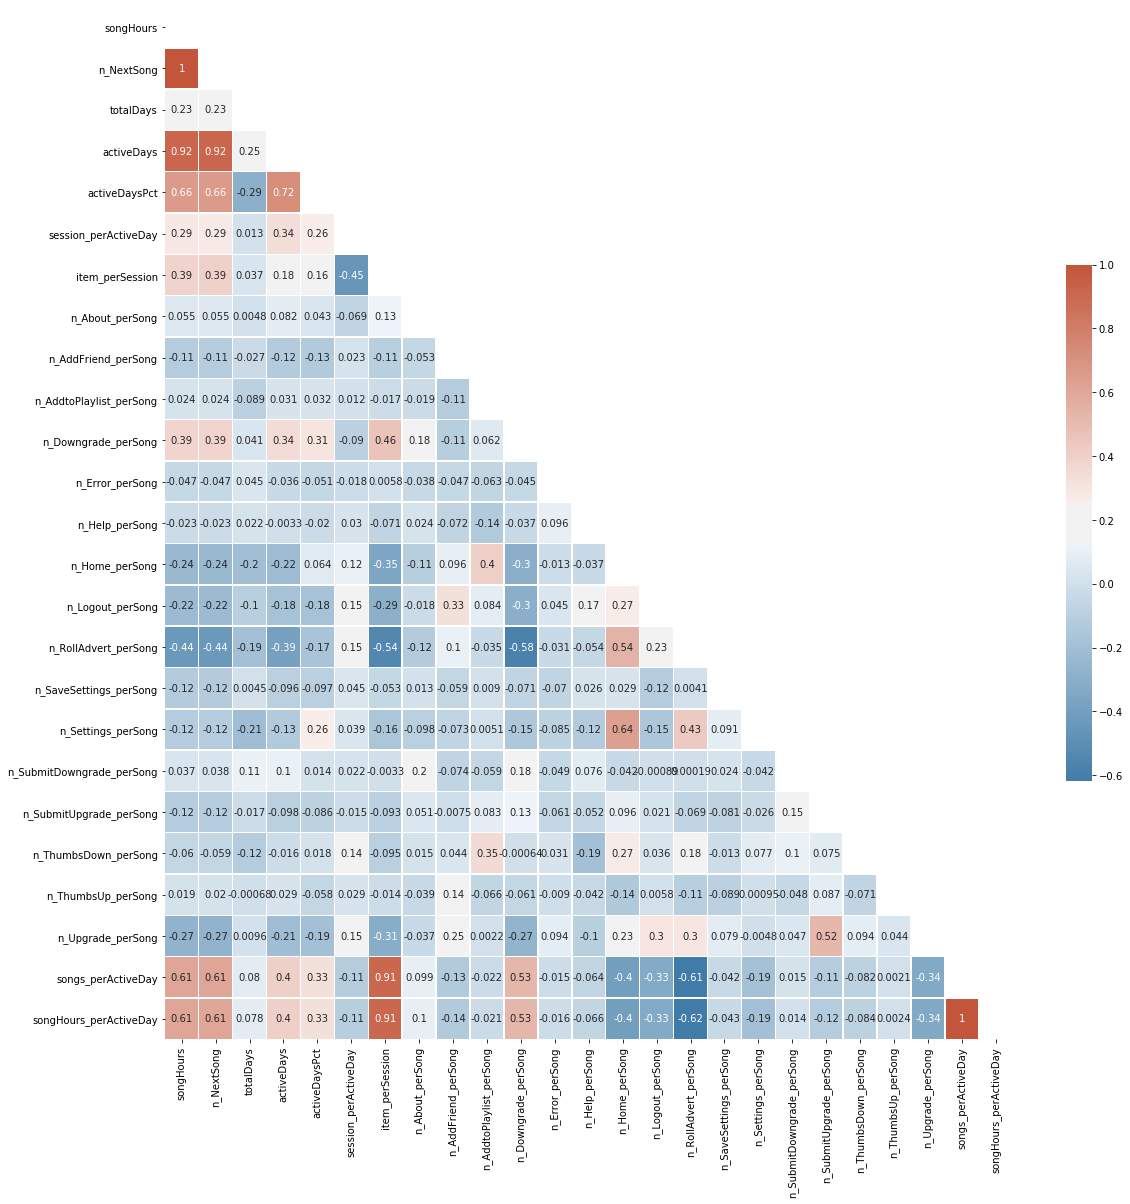

In [49]:
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, LongType))]

df_numeric_cols_panda = df.select(numeric_cols).toPandas()
corrMatrix = df_numeric_cols_panda.corr()

# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(240, 20, sep=20, n=20, as_cmap=True)
plt.figure(figsize=(19,19))
sn.heatmap(corrMatrix, annot=True, cmap=cmap, mask=mask, linewidths=.5, linecolor='white', cbar_kws={"shrink": .5})
plt.show()

In [50]:
# drop columns with correlation > 0.8
numeric_cols_drop = ['activeDays', 'n_NextSong', 'songHours', 'songs_perActiveDay', 'item_perSession']

# numeric columns after dropping high correlation features
numeric_cols = list(set(numeric_cols) - set(numeric_cols_drop))

df = df.drop(*numeric_cols_drop)

# categorical_cols = ['gender', 'registrationYearMonth', 'state', 'system', 'level']
# 'gender', 'system', 'level' were chosen as categorical features for further analysis as each of them has 2 or 3 levels. 
# categorical_cols = ['gender', 'system', 'level']
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
categorical_cols.remove('userId')

In [51]:
df2 = df

In [299]:
def data_assembler_scaler(df, numeric_cols, categorical_cols):
    '''
    This function 
    
    INPUT:
    df - pyspark dataframe containing features about each individual user
    numeric_cols - list of all numeric columns in df
    categorical_cols - list of all categorical columns in df
    
    OUTPUT:
    df - vectorized features of each individual user
    
    '''    
      
    stages = []
    for column in categorical_cols:
        stringIndexer = StringIndexer(inputCol=column, outputCol=column + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[column + "Index"], outputCols=[column + "Vec"], dropLast=False)
        stages += [stringIndexer, encoder]

    # https://stackoverflow.com/questions/60281354/apply-minmaxscaler-on-multiple-columns-in-pyspark
    # assemble all numeric cols into one col and scale will lose all column names

    label_indexer = StringIndexer(inputCol = 'churn', outputCol = 'label')
    stages += [label_indexer]

    numericInputs = numeric_cols  
    categoricalInputs = [c + "Vec" for c in categorical_cols]
    assembler = VectorAssembler(inputCols= numericInputs + categoricalInputs, outputCol='features')
    stages += [assembler]

    pipeline = Pipeline(stages=stages)
    df = pipeline.fit(df).transform(df)

    # select data for analysis
    df = df.select('label', 'features')

    return df

df = data_assembler_scaler(df, numeric_cols=numeric_cols, categorical_cols=categorical_cols)
df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.01818,0.01818,...|
|  0.0|[0.0155,0.01292,0...|
|  0.0|(27,[2,5,10,13,18...|
|  1.0|(27,[2,5,10,13,18...|
|  0.0|[0.01005,0.01446,...|
+-----+--------------------+
only showing top 5 rows



### Train Test Split

In [14]:
def train_test_sampling(data, ratio=0.8, label='label', seed=42):
    '''
    This function splits unbalanced data into train and test data using stratified sampling, 
    so the train/test datasets have similar 'churn'/'not churn' ratios to that of the whole dataset.

    INPUT:
    data - features dataframe specific to each individual user
    ratio - proportion of data that will be split into train dataset
    label - feature/column that defines strata. default value 'label'
    seed - random seed. default value 42
    
    OUTPUT:
    train - A new SparkDataFrame that represents the stratified train datasest
    test - A new SparkDataFrame that represents the stratified test dataset
    
    '''
    
    train = data.sampleBy(col='label', fractions={0: ratio, 1: ratio}, seed=seed)
    test = data.subtract(train)
    return train, test

In [302]:
train, test = train_test_sampling(df)

print("Training Dataset records number: " + str(train.count()))
print("Test Dataset records number: " + str(test.count()))

Training Dataset records number: 193
Test Dataset records number: 33


### Model Metrics Calculation

In [ ]:
def metrics_calculation(model, data):
    '''
    This function takes a trained model and data and returns accuracy, precision, recall, F1 and areaUnderROC.

    INPUT:
    model - a trained model
    data - data to apply the trained model
    
    OUTPUT:
    model_metrics - (pandas dataframe) accuracy, precision, recall, F1 and areaUnderROC
    
    '''
    
    predictions = model.transform(data)

    TN = predictions.filter('label = 0 and prediction = 0').count()
    TP = predictions.filter('label = 1 and prediction = 1').count()
    FN = predictions.filter('label = 1 and prediction = 0').count()
    FP = predictions.filter('label = 0 and prediction = 1').count()

    # calculate accuracy, precision, recall, F1-score, and areaUnderROC
    accuracy = (TN + TP) / (TN + TP + FN + FP)

    if TP == 0 and FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP==0 and FN==0:
        recall = 0
    else:
        recall = TP / (TP + FN)

    if precision==0 and recall==0:
        F1=0
    else:
        F1 =  2 * (precision*recall) / (precision + recall)
        
    areaUnderROC = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    
    model_metrics = pd.DataFrame({'accuracy':[accuracy], 'precision':[precision], \
                                  'recall':[recall], 'F1':[F1], 'areaUnderROC':[areaUnderROC]})
    
#    model_metrics.insert(0, 'model', model.uid.split('_')[0])
    return model_metrics

In [15]:
def metrics_train_test(model, train, test):
    '''
    This function takes a trained model, train and test data 
    and returns accuracy, precision, recall, F1 and areaUnderROC (pandas dataframe) for both train and test dataset.

    INPUT:
    model - a trained model
    train - train data to apply the trained model
    test - test data to apply the trained model
    
    OUTPUT:
    model_metrics - (pandas dataframe) accuracy, precision, recall, F1 and areaUnderROC for both train and test dataset
    
    '''
    
    train_metrics = metrics_calculation(model=model, data=train)
    test_metrics = metrics_calculation(model=model, data=test)
    
    model_metrics = pd.concat(dict(TRAIN = train_metrics, TEST = test_metrics),axis=1)

    model_metrics.insert(0, 'model', model.uid.split('_')[0]) 
    return model_metrics

In [281]:
def fit_model(base_model, grid, evaluator, data, numFolds=4, seed=42):
    '''
    This function applies K-fold cross validation to data using provided grid and returns model and run time.

    INPUT:
    base_model - initialized model
    grid - grid parameters 
    evaluator - metric to compare models
    data - data to apply the base model
    numFolds - number of splits for cross validation, default 4
    seed - random seed, default 42
    
    OUTPUT:
    model - models for all grid parameters
    t - run time
    
    '''
    
    cv = CrossValidator(estimator=base_model,
               estimatorParamMaps=grid,
               evaluator=evaluator,
               numFolds = numFolds,
               seed = seed
               )
    
    start_time = time.time()
    model = cv.fit(data)
    t = time.time() - start_time
        
#    best_model = model.bestModel

    return model, t

In [17]:
def best_model_and_all_metrics(base_model, grid, evaluator, data, numFolds=4, seed=42):
    '''
    This function applies K-fold cross validation to data using provided grid and returns the best model and model metrics

    INPUT:
    base_model - initialized model
    grid - grid parameters 
    evaluator - metric to compare models
    data - data to apply the base model
    numFolds - number of splits for cross validation, default 4
    seed - random seed, default 42

    
    OUTPUT:
    best_model - best model after comparing evaluator
    model_metrics - best model accuracy, precision, recall, F1 and areaUnderROC for both train and test dataset
                    (pandas dataframe)
    
    '''
    
    train, test = train_test_sampling(data=data)
    
    model, t = fit_model(base_model=base_model, grid=grid, \
                               evaluator=evaluator, data=train, numFolds=numFolds, seed=seed)
    
    best_model = model.bestModel
    model_metrics = metrics_train_test(model=best_model, test=test, train=train)
    model_metrics['TRAIN', 'training time (s)'] = t
#    model_metrics = model_metrics.sort_index(axis=1, ascending=False)
        
    return best_model, model_metrics

### Apply model metrics function to 
1. LogisticRegression
2. RandomForestClassifier
3. GBTClassifier

In [7]:
#1 logistic regression
lr = LogisticRegression()

# Create the parameter grid, add hyperparameters, and build the grid
grid1 = ParamGridBuilder() \
        .addGrid(lr.regParam, [0, 0.01, .1]) \
        .addGrid(lr.elasticNetParam, [0, .5, 1]) \
        .addGrid(lr.maxIter, [50, 100, 150]) \
        .build()

In [9]:
#2 RandomForestClassifier
rf = RandomForestClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid2 = ParamGridBuilder() \
        .addGrid(rf.numTrees, [10, 20, 30]) \
        .addGrid(rf.maxBins, [16, 32, 48]) \
        .addGrid(rf.maxDepth, [3, 5, 10]) \
        .build()

In [8]:
#3 GBTClassifier
gbt = GBTClassifier()

# Create the parameter grid, add hyperparameters, and build the grid
grid3 = ParamGridBuilder() \
        .addGrid(gbt.maxDepth, [3, 5, 10]) \
        .addGrid(gbt.maxBins, [16, 32, 48]) \
        .addGrid(gbt.maxIter, [10, 20, 30]) \
        .addGrid(gbt.stepSize, [0.1, 0.5, 1])
        .build()

In [304]:
evaluator = BinaryClassificationEvaluator(metricName = 'areaUnderROC')

In [308]:
# get the best model, and model metrics for each model algorism
lr_best_model, lr_model_metrics = best_model_and_all_metrics(base_model=lr, grid=grid1, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
rf_best_model, rf_model_metrics = best_model_and_all_metrics(base_model=rf, grid=grid2, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)
gbt_best_model, gbt_model_metrics = best_model_and_all_metrics(base_model=gbt, grid=grid3, \
                                                             evaluator=evaluator, data=df, numFolds=4, seed=42)

In [385]:
# save model
lr_best_model.save('lr_best_model.pkl')
rf_best_model.save('rf_best_model.pkl') 
gbt_best_model.save('gbt_best_model.pkl')

### Compare model metrics
Comparing the metrics of three models, apparently, LogisticRegression has the worse metrics, pretty much in every aspect. RandomForestClassifier and GBTClassifier have close areaUnderROC. RandomForestClassifier has significanlty less training time than GBTClassifier, while GBTClassifier has significantly higher recall and F1 than RandomForestClassifier. To finalize which of the two models is better, comparision will be made on analyzing the full dataset on AWS.

In [309]:
# combine model metrics into one pandas dataframe
pd.concat([lr_model_metrics, rf_model_metrics, gbt_model_metrics])

model     TRAIN                                \
                           accuracy precision    recall        F1   
0      LogisticRegression  0.854922  0.833333  0.454545  0.588235   
0  RandomForestClassifier  0.927461  1.000000  0.681818  0.810811   
0           GBTClassifier  0.994819  1.000000  0.977273  0.988506   

                    TEST                                       \
  areaUnderROC  accuracy precision recall     F1 areaUnderROC   
0     0.869509  0.757576     0.000  0.000  0.000        0.655   
0     0.988941  0.818182     1.000  0.250  0.400        0.830   
0     0.999924  0.818182     0.625  0.625  0.625        0.825   

              TRAIN  
  training time (s)  
0        628.794265  
0        209.656406  
0       3276.305505

### Feature Importance
The analysis was performed on a small sample dataset. It does give us a sense of which features are important.
For GBTClassifier, 
1. It seems most features related to page views per song are important. TotalDays and n_ThumbsDown_perSong are the top 2 important features, followed by session_perActiveDay, n_About_perSong, n_logout_perSong, n_AddFriend_perSong etc.. 
2. User systems (PC/Apple/Linux), user gender (M/F), or user level (free/paid) are the least important features.

In [310]:
# https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    '''
    This function returns the feature/column names sorted by importance score as pandas dataframe

    INPUT:
    featureImp - the best model featureImportances (sparse vector)
    dataset - original dataset a model was applied
    featuresCol - features column (vector)
    
    OUTPUT:
    varlist - feature/column names sorted by importance score as pandas dataframe
    
    '''
    
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist = varlist.sort_values('score', ascending = False)
    return varlist

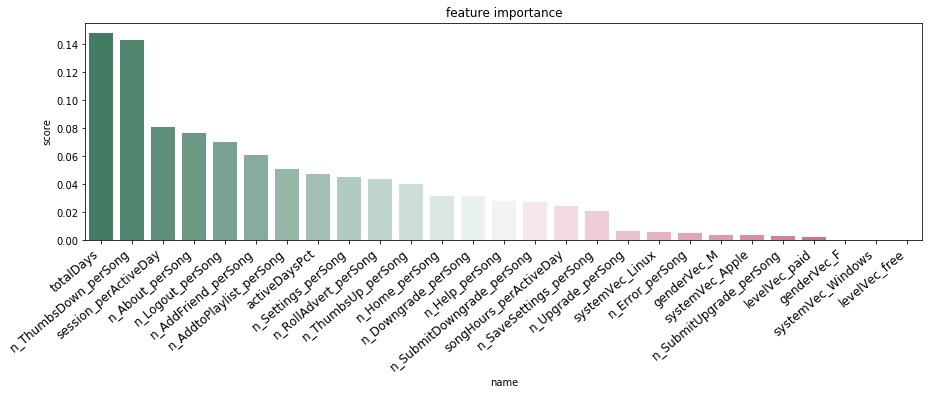

In [316]:
df_feature_importance = ExtractFeatureImp(gbt_best_model.featureImportances, df, "features")

# plot model's correlation coefficients
plt.figure(figsize=(15, 4));

palette = sn.diverging_palette(150, 0, n=27)

sn.barplot(x=df_feature_importance.name, y=df_feature_importance.score, data=df_feature_importance, palette=palette)
plt.xticks(rotation=40, ha='right', fontsize=12)
plt.title('feature importance');